# Optimization project Iver & Alessandro 

In [210]:
import gurobipy as gp
from gurobipy import GRB
from enum import Enum
import numpy as np
from functools import lru_cache
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as mp_anim
import matplotlib.patches as ptch
import matplotlib.colors as mpcol
import matplotlib.cm as cm


BEGIN_UNDERLINE = "\033[4m"
END_UNDERLINE = "\033[0m"

GREEN_COLOR = "\033[92m"
RED_COLOR = "\033[91m"
END_COLOR = "\033[0m"

print(sys.version)

3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


# Taxi game

In [135]:
TAXI_MAP_SIZE = 5

class TaxiTile(Enum):
    EMPTY = 0
    BUILDING = 1
    PICK_UP = 2
    DROP_OFF = 3

    def __eq__(self, other):
        if  other.__class__ is self.__class__:
            return self.value == other.value
        elif self.value == other:
            return True
        else:
            return False


# Remember to index as [y, x]
taxi_mappy = np.array(
[
    [0, 1, 0, 0, 0,],
    [0, 0, 0, 1, 0,],
    [0, 1, 0, 1, 3,],
    [0, 1, 0, 0, 0,],
    [2, 1, 1, 0, 0,]
])

In [136]:
class TaxiAction(Enum):
    MOVE_SOUTH = 0
    MOVE_NORTH = 1
    MOVE_EAST = 2
    MOVE_WEST = 3
    PICK_UP = 4
    DROP_OFF = 5


class FaultyPassengerAction(Exception):
    pass


class FaultyMove(Exception):
    pass


def taxi_do_action(x, y, passenger, action) -> tuple[int, int, bool, Exception | None]:
    if action == TaxiAction.PICK_UP:
        if passenger or taxi_mappy[x, y] != TaxiTile.PICK_UP:
            return x, y, passenger, FaultyPassengerAction
        return x, y, True, None
    elif action == TaxiAction.DROP_OFF:
        if (not passenger) or taxi_mappy[x, y] != TaxiTile.DROP_OFF:
            return x, y, passenger, FaultyPassengerAction
        return x, y, False, None

    nx, ny = x, y
    if action == TaxiAction.MOVE_NORTH:
        nx -= 1
    elif action == TaxiAction.MOVE_SOUTH:
        nx += 1
    elif action == TaxiAction.MOVE_EAST:
        ny += 1
    elif action == TaxiAction.MOVE_WEST:
        ny -= 1

    if nx < 0 or ny < 0 or nx >= TAXI_MAP_SIZE or ny >= TAXI_MAP_SIZE:
        return x, y, passenger, FaultyMove
    elif taxi_mappy[nx, ny] == TaxiTile.BUILDING:
        return x, y, passenger, FaultyMove
    else:
        return nx, ny, passenger, None


def taxi_get_idx(x: int, y: int, passenger: int | bool) -> int:
    return x + y * TAXI_MAP_SIZE + int(passenger) * TAXI_MAP_SIZE * TAXI_MAP_SIZE


def taxi_get_state(idx: int) -> tuple[int, int, bool]:
    passenger = idx // (TAXI_MAP_SIZE * TAXI_MAP_SIZE)
    rest = idx % (TAXI_MAP_SIZE * TAXI_MAP_SIZE)
    y = rest // TAXI_MAP_SIZE
    x = idx % TAXI_MAP_SIZE
    return x, y, bool(passenger)


_tst_state = 2, 3, True
_tst_state_2 = taxi_get_state(taxi_get_idx(_tst_state[0], _tst_state[1], _tst_state[2]))
assert _tst_state_2 == _tst_state


def taxi_iterstates():
    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            if taxi_mappy[x, y] == TaxiTile.BUILDING:
                # Skip all buildings
                continue
            for passenger in [0, 1]:
                yield x, y, passenger

In [252]:
taxi_m = gp.Model("taxi_driver")

taxi_V = np.empty((TAXI_MAP_SIZE * TAXI_MAP_SIZE * 2), dtype=object)
taxi_Q = np.empty((TAXI_MAP_SIZE * TAXI_MAP_SIZE * 2, len(TaxiAction)), dtype=object)
taxi_constraints = np.empty((TAXI_MAP_SIZE * TAXI_MAP_SIZE * 2, len(TaxiAction)), dtype=object)

taxi_gamma = 0.7

for x, y, passenger in taxi_iterstates():
    # Insert a state
    taxi_V[taxi_get_idx(x, y, passenger)] = taxi_m.addVar(lb=-float("inf"))
for x, y, passenger in taxi_iterstates():
    # Create list of all transitions away from this given state
    for action in TaxiAction:
        reward = -1  # For using a timestep

        nx, ny, npass, error = taxi_do_action(x, y, passenger, action)
        if error == FaultyPassengerAction:
            reward -= 10
        elif action == TaxiAction.DROP_OFF:
            # Successfull drop off
            reward += 20
        elif error == FaultyMove:
            continue  # Skip all impossible moves

        q = taxi_m.addVar(lb=-float("inf"))
        taxi_Q[taxi_get_idx(x, y, passenger), action.value] = q
        taxi_m.addConstr(
            q == reward + taxi_gamma * taxi_V[taxi_get_idx(nx, ny, npass)]
        )
        gt_constr = taxi_m.addConstr(
            taxi_V[taxi_get_idx(x, y, passenger)]
            >= q
        )
        # store constraints to get dual variables
        taxi_constraints[taxi_get_idx(x, y, passenger), action.value] = gt_constr

taxi_m.setObjective(
    (1 - taxi_gamma) * gp.quicksum(taxi_V[taxi_V != None]),
    sense=GRB.MINIMIZE,
)

# taxi_m.params.LogToConsole = 0
taxi_m.params.Method = GRB.METHOD_PRIMAL
# taxi_m.params.Method = GRB.METHOD_DUAL
taxi_m.optimize()


Set parameter Method to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 296 rows, 184 columns and 592 nonzeros
Model fingerprint: 0x1ce19598
Coefficient statistics:
  Matrix range     [7e-01, 1e+00]
  Objective range  [3e-01, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 248 rows and 151 columns
Presolve time: 0.01s
Presolved: 48 rows, 33 columns, 160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0836675e+01   1.886277e+01   1.791869e+07      0s
      25    6.0746890e-02   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.074689036e-02


In [246]:
print("Dual variables", end="\n\n")
for passenger in [0, 1]:
    print("With passenger:") if passenger else print("No passenger:")
    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            if taxi_mappy[x, y] == TaxiTile.BUILDING:
                print(f"  B  ", end=" ")
            else:
                summy = 0
                county = 0
                for a in TaxiAction:
                    constr = taxi_constraints[taxi_get_idx(x, y, passenger), a.value]
                    if type(constr) != gp.Constr:
                        continue
                    pi = constr.Pi
                    if pi != 0.0:
                        county += 1
                        summy += pi
                if county > 1:
                    print("As we can see, only one action has a dual value g.t. 0.0 per state")
                print(f"{summy:05.2f}", end=" ")
        print()
    print()

Dual variables

No passenger:
00.30   B   00.76 00.66 00.51 
01.58 01.52 01.75   B   00.30 
01.40   B   01.31   B   01.56 
01.28   B   01.44 01.63 01.60 
01.20   B     B   00.30 00.30 

With passenger:
00.30   B   01.09 01.06 01.04 
01.26 01.18 01.13   B   01.03 
01.07   B   00.30   B   01.80 
01.10   B   00.51 00.87 01.12 
01.14   B     B   00.30 00.30 



In [247]:
print("State values", end="\n\n")
for passenger in [0, 1]:
    print("With passenger:") if passenger else print("No passenger:")
    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            if taxi_mappy[x, y] == TaxiTile.BUILDING:
                print(f"  B  ", end=" ")
            else:
                print(f"{taxi_V[taxi_get_idx(x, y, passenger)].X:05.2f}", end=" ")
        print()
    print()

State values

No passenger:
-3.24   B   -3.29 -3.30 -3.31 
-3.20 -3.24 -3.27   B   -3.32 
-3.14   B   -3.29   B   -3.32 
-3.06   B   -3.30 -3.31 -3.32 
-2.94   B     B   -3.32 -3.32 

With passenger:
-2.18   B   01.47 03.53 06.47 
-1.69 -0.98 00.03   B   10.67 
-2.18   B   01.47   B   16.67 
-2.53   B   03.53 06.47 10.67 
-2.77   B     B   03.53 06.47 



In [139]:
taxi_optimal_steps = [(0, 0, False)]

while True:
    x, y, pngr = taxi_optimal_steps[-1]

    choice = None
    vmax = -float("inf")
    for a in TaxiAction:
        q = taxi_Q[taxi_get_idx(x, y, pngr), a.value]
        val = q.X if type(q) == gp.Var else -float("inf")
        if val > vmax:
            vmax = val
            choice = a

    # print(choice, vmax)
    nx, ny, npass, error = taxi_do_action(x, y, pngr, choice)
    if (nx, ny, npass) in taxi_optimal_steps:
        taxi_optimal_steps.append((nx, ny, npass))
        break
    else:
        taxi_optimal_steps.append((nx, ny, npass))


Text(0.5, 0.98, 'Optimal direction and log of value per state for taxi problem')

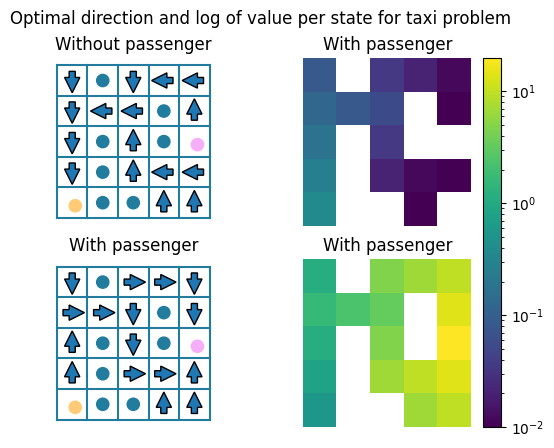

In [231]:
fig, axs = plt.subplots(2, 2)
axs1: list[plt.Axes] = axs[:, 0]
axs2: list[plt.Axes] = axs[:, 1]

for ax, passenger in zip(axs1, [False, True]):
    ax.set_title("With passenger" if passenger else "Without passenger")
    ax.yaxis.set_inverted(True)
    ax.axis("off")
    ax.set_aspect(1)

    def taxi_get_q(x, y, passenger, a):
        q = taxi_Q[taxi_get_idx(x, y, passenger), a.value]
        if type(q) != gp.Var:
            return -float("inf")
        return q.X

    for i in range(5 + 1):
        ax.plot(np.ones(100) * i, np.linspace(0, 5, 100), color="#227C9D")
        ax.plot(np.linspace(0, 5, 100), np.ones(100) * i, color="#227C9D")

    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            if taxi_mappy[x, y] == TaxiTile.BUILDING:
                circle = ptch.Circle((y + 0.5, x + 0.5), 0.2, color='#227C9D')
                ax.add_patch(circle)
            elif taxi_mappy[x, y] == TaxiTile.DROP_OFF:
                circle = ptch.Circle((y + 0.6, x + 0.6), 0.2, color='#F7AEF8')
                ax.add_patch(circle)
            elif taxi_mappy[x, y] == TaxiTile.PICK_UP:
                circle = ptch.Circle((y + 0.6, x + 0.6), 0.2, color='#FFCB77')
                ax.add_patch(circle)
            else:
                action = max(TaxiAction, key=lambda a: taxi_get_q(x, y, passenger, a))
                if action == TaxiAction.MOVE_SOUTH:
                    arrow = ptch.FancyArrow(y + 0.5, x + 0.2, 0, 0.2, head_width=0.5, width=0.2, head_length=0.5)
                    ax.add_patch(arrow)
                elif action == TaxiAction.MOVE_NORTH:
                    arrow = ptch.FancyArrow(y + 0.5, x + 0.8, 0, -0.2, head_width=0.5, width=0.2, head_length=0.5)
                    ax.add_patch(arrow)
                elif action == TaxiAction.MOVE_EAST:
                    arrow = ptch.FancyArrow(y + 0.2, x + 0.5, 0.2, 0, head_width=0.5, width=0.2, head_length=0.5)
                    ax.add_patch(arrow)
                elif action == TaxiAction.MOVE_WEST:
                    arrow = ptch.FancyArrow(y + 0.8, x + 0.5, -0.2, 0, head_width=0.5, width=0.2, head_length=0.5)
                    ax.add_patch(arrow)

listy: list[np.ndarray] = []

for passenger in [False, True]:
    vals = np.zeros((TAXI_MAP_SIZE, TAXI_MAP_SIZE))
    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            v = taxi_V[taxi_get_idx(x, y, passenger)]
            v = v.X if type(v) == gp.Var else -float("inf")
            vals[x, y] = v
    listy.append(vals)

minny = min([vals[vals != float("-inf")].min() for vals in listy])
maxxy = max([vals.max() for vals in listy])
normalizer=mpcol.LogNorm(vmin=0.01, vmax=maxxy - minny)

for ax, vals in zip(axs2, listy):
    ax.set_title("With passenger" if passenger else "Without passenger")
    ax.yaxis.set_inverted(True)
    ax.axis("off")
    ax.set_aspect(1)
    c = ax.imshow(vals - minny, norm=normalizer)

fig.colorbar(c, ax=axs2)
fig.suptitle("Optimal direction and log of value per state for taxi problem")

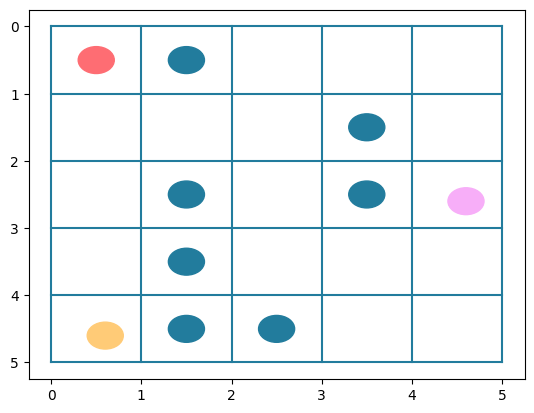

In [140]:
fig, ax = plt.subplots()
ax.yaxis.set_inverted(True)


for i in range(5 + 1):
    ax.plot(np.ones(100) * i, np.linspace(0, 5, 100), color="#227C9D")
    ax.plot(np.linspace(0, 5, 100), np.ones(100) * i, color="#227C9D")

for x in range(TAXI_MAP_SIZE):
    for y in range(TAXI_MAP_SIZE):
        if taxi_mappy[x, y] == TaxiTile.BUILDING:
            circle = plt.Circle((y + 0.5, x + 0.5), 0.2, color='#227C9D')
            ax.add_patch(circle)
        elif taxi_mappy[x, y] == TaxiTile.DROP_OFF:
            circle = plt.Circle((y + 0.6, x + 0.6), 0.2, color='#F7AEF8')
            ax.add_patch(circle)
        elif taxi_mappy[x, y] == TaxiTile.PICK_UP:
            circle = plt.Circle((y + 0.6, x + 0.6), 0.2, color='#FFCB77')
            ax.add_patch(circle)

taxi = plt.Circle((0 + 0.5, 0 + 0.5), 0.2, color='r')
ax.add_patch(taxi)

def animate(i):
    x, y, png = taxi_optimal_steps[i]
    taxi.set_center((y + 0.5, x + 0.5))
    color = "#fe6d73" if not png else "#17c3b2"
    taxi.set_color(color)

ani = mp_anim.FuncAnimation(fig, animate, frames=len(taxi_optimal_steps))

from IPython.display import HTML
HTML(ani.to_jshtml())

# Blackjack

In [141]:
# Assumptions:
#   - Every draw is independent of the previous draws,
#     meaning the probability of drawing 5 (or 10 000) of the same card is nonzero.
#   - The player has a fixed policy of always drawing until his score is 12 or higher,
#     because below that it is impossible to bust.


class BJAction(Enum):
    Hit = 0
    Stand = 1


POSSIBLE_DRAWS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card():
    return np.random.choice(POSSIBLE_DRAWS, replace=True)


POSSIBLE_SUMS = range(12, 21 + 1)
POSSIBLE_DEALER_FACES = range(1, 10 + 1)


@lru_cache
def calculate_stand_score(dealer_sum, player_sum) -> float:
    scory = 0.0
    for draw in POSSIBLE_DRAWS:
        ds = dealer_sum + draw
        if ds < 17:
            scory += calculate_stand_score(ds, player_sum) / len(
                POSSIBLE_DRAWS
            )
        elif ds > 21:
            scory += 1.0 / len(POSSIBLE_DRAWS)
        elif ds == player_sum:
            scory += 0
        elif ds < player_sum:
            scory += 1.0 / len(POSSIBLE_DRAWS)
        elif ds > player_sum:
            scory -= 1.0 / len(POSSIBLE_DRAWS)
        else:
            print("ERROR")
    return scory

# calculate_stand_score(10, 18)

In [142]:
# Printing value space
print(BEGIN_UNDERLINE, end="")
print("   | ", end="")
for ms in POSSIBLE_SUMS:
    print(f"{ms:7}", end=" | ")
print(END_UNDERLINE, end="")
print()
for df in POSSIBLE_DEALER_FACES:
    print(f"{df:2}", end=" | ")
    for ms in POSSIBLE_SUMS:
        score = calculate_stand_score(df, ms)
        print(f"{score:7.4f}", end=" | ")
    print()

   |      12 |      13 |      14 |      15 |      16 |      17 |      18 |      19 |      20 |      21 | 
 1 | -0.3959 | -0.3959 | -0.3959 | -0.3959 | -0.3959 | -0.2527 |  0.0270 |  0.2931 |  0.5444 |  0.8331 | 
 2 | -0.2542 | -0.2542 | -0.2542 | -0.2542 | -0.2542 | -0.1155 |  0.1556 |  0.4141 |  0.6588 |  0.8888 | 
 3 | -0.2174 | -0.2174 | -0.2174 | -0.2174 | -0.2174 | -0.0834 |  0.1790 |  0.4295 |  0.6674 |  0.8915 | 
 4 | -0.1794 | -0.1794 | -0.1794 | -0.1794 | -0.1794 | -0.0501 |  0.2033 |  0.4458 |  0.6764 |  0.8943 | 
 5 | -0.1407 | -0.1407 | -0.1407 | -0.1407 | -0.1407 | -0.0160 |  0.2284 |  0.4626 |  0.6859 |  0.8973 | 
 6 | -0.1015 | -0.1015 | -0.1015 | -0.1015 | -0.1015 |  0.0185 |  0.2539 |  0.4799 |  0.6956 |  0.9004 | 
 7 | -0.4294 | -0.4294 | -0.4294 | -0.4294 | -0.4294 | -0.0488 |  0.4226 |  0.5994 |  0.7668 |  0.9240 | 
 8 | -0.4702 | -0.4702 | -0.4702 | -0.4702 | -0.4702 | -0.3310 |  0.1781 |  0.6280 |  0.7835 |  0.9295 | 
 9 | -0.5080 | -0.5080 | -0.5080 | -0.5080 | -

In [143]:
bj_model = gp.Model("blackjack_bajillionaire")
bj_gamma = 0.9

bj_V = np.empty((len(POSSIBLE_SUMS), len(POSSIBLE_DEALER_FACES)), dtype=object)
for my_sum in POSSIBLE_SUMS:
    for dealer_face in POSSIBLE_DEALER_FACES:
        bj_V[my_sum - 12, dealer_face - 1] = bj_model.addVar(lb=-float("inf"))

for my_sum in POSSIBLE_SUMS:
    for dealer_face in POSSIBLE_DEALER_FACES:
        for action in BJAction:
            if action == BJAction.Stand:
                score = calculate_stand_score(dealer_face, my_sum)
                bj_model.addConstr(bj_V[my_sum - 12, dealer_face - 1] >= score)

            elif action == BJAction.Hit:
                prob_const = 1 / len(POSSIBLE_DRAWS)
                reward = (
                    -len([-1 for draw in POSSIBLE_DRAWS if my_sum + draw > 21])
                    * prob_const
                )

                bj_model.addConstr(
                    bj_V[my_sum - 12, dealer_face - 1]
                    >= reward + bj_gamma
                    * gp.quicksum(
                        [
                            bj_V[my_sum + draw - 12, dealer_face - 1]
                            for draw in POSSIBLE_DRAWS
                            if my_sum + draw <= 21
                        ]
                    )
                    * prob_const
                )

bj_model.setObjective((1 - bj_gamma) * gp.quicksum(bj_V[bj_V != None]), sense=GRB.MINIMIZE)
bj_model.optimize()

# We make the Q matrix after solving the problem because it avoids accidentally messing something up
bj_Q = np.empty((len(POSSIBLE_SUMS), len(POSSIBLE_DEALER_FACES), 2), dtype=object)

for my_sum in POSSIBLE_SUMS:
    for dealer_face in POSSIBLE_DEALER_FACES:
        for action in BJAction:
            if action == BJAction.Stand:
                score = calculate_stand_score(dealer_face, my_sum)
                bj_Q[my_sum - 12, dealer_face - 1, BJAction.Stand.value] = score

            elif action == BJAction.Hit:
                prob_const = 1 / len(POSSIBLE_DRAWS)
                reward = (
                    -len([-1 for draw in POSSIBLE_DRAWS if my_sum + draw > 21])
                    * prob_const
                )

                bj_Q[my_sum - 12, dealer_face - 1, BJAction.Hit.value] = reward + bj_gamma * sum(
                    [
                        bj_V[my_sum + draw - 12, dealer_face - 1].X
                        for draw in POSSIBLE_DRAWS
                        if my_sum + draw <= 21
                    ]
                ) * prob_const

my_sum = 14
dealer_face = 7
print(bj_Q[my_sum - 12, dealer_face - 1, BJAction.Stand.value])
print(bj_Q[my_sum - 12, dealer_face - 1, BJAction.Hit.value])

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 200 rows, 100 columns and 650 nonzeros
Model fingerprint: 0xa6518bb9
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  Objective range  [1e-01, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+00]
Presolve removed 200 rows and 100 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4663437e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.466343740e-01
-0.42940497270084854
-0.3333972073039268


In [144]:
# Printing value space
print(BEGIN_UNDERLINE, end="")
print("   | ", end="")
for ms in POSSIBLE_SUMS:
    print(f"{ms:6}", end=" | ")
print(END_UNDERLINE, end="")
print()
for df in POSSIBLE_DEALER_FACES:
    print(f"{df:2}", end=" | ")
    for ms in POSSIBLE_SUMS:
        value = bj_V[ms - 12, df - 1].X
        print(f"{value:6.4f}", end=" | ")
    print()

   |     12 |     13 |     14 |     15 |     16 |     17 |     18 |     19 |     20 |     21 | 
 1 | -0.3153 | -0.3668 | -0.3959 | -0.3959 | -0.3959 | -0.2527 | 0.0270 | 0.2931 | 0.5444 | 0.8331 | 
 2 | -0.2395 | -0.2542 | -0.2542 | -0.2542 | -0.2542 | -0.1155 | 0.1556 | 0.4141 | 0.6588 | 0.8888 | 
 3 | -0.2174 | -0.2174 | -0.2174 | -0.2174 | -0.2174 | -0.0834 | 0.1790 | 0.4295 | 0.6674 | 0.8915 | 
 4 | -0.1794 | -0.1794 | -0.1794 | -0.1794 | -0.1794 | -0.0501 | 0.2033 | 0.4458 | 0.6764 | 0.8943 | 
 5 | -0.1407 | -0.1407 | -0.1407 | -0.1407 | -0.1407 | -0.0160 | 0.2284 | 0.4626 | 0.6859 | 0.8973 | 
 6 | -0.1015 | -0.1015 | -0.1015 | -0.1015 | -0.1015 | 0.0185 | 0.2539 | 0.4799 | 0.6956 | 0.9004 | 
 7 | -0.2220 | -0.2796 | -0.3334 | -0.3838 | -0.4294 | -0.0488 | 0.4226 | 0.5994 | 0.7668 | 0.9240 | 
 8 | -0.2652 | -0.3200 | -0.3712 | -0.4191 | -0.4639 | -0.3310 | 0.1781 | 0.6280 | 0.7835 | 0.9295 | 
 9 | -0.3181 | -0.3695 | -0.4175 | -0.4624 | -0.5044 | -0.3788 | -0.1203 | 0.3689 | 0.798

In [145]:
# Printing value space
print(BEGIN_UNDERLINE, end="")
print("   | ", end="")
for ms in POSSIBLE_SUMS:
    print(f"{ms:6}", end=" | ")
print(END_UNDERLINE, end="")
print()
for df in POSSIBLE_DEALER_FACES:
    print(f"{df:2}", end=" | ")
    for ms in POSSIBLE_SUMS:
        action = max(BJAction, key=lambda a: bj_Q[ms - 12, df - 1, a.value])
        print(f"{action.name:6}", end=" | ")
    print()

   |     12 |     13 |     14 |     15 |     16 |     17 |     18 |     19 |     20 |     21 | 
 1 | Hit    | Hit    | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 2 | Hit    | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 3 | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 4 | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 5 | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 6 | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 7 | Hit    | Hit    | Hit    | Hit    | Stand  | Stand  | Stand  | Stand  | Stand  | Stand  | 
 8 | Hit    | Hit    | Hit    | Hit    | Hit    | Stand  | Stand  | Stand  | Stand  | Stand  | 
 9 | Hit    | Hit    | Hit    | Hit    | Hit    | Stand  | Stand  | Stand  | Stand  | Stand  | 
10 | Hit    | Hit    | Hit    | Hit    |

In [146]:
# Printing value space
print(BEGIN_UNDERLINE, end="")
print("   | ", end="")
for ms in POSSIBLE_SUMS:
    print(f"{ms:7}", end=" | ")
print(END_UNDERLINE, end="")
print()
for df in POSSIBLE_DEALER_FACES:
    print(f"{df:2}", end=" | ")
    for ms in POSSIBLE_SUMS:
        action = max(BJAction, key=lambda a: bj_Q[ms - 12, df - 1, a.value])
        color = GREEN_COLOR if action == BJAction.Hit else RED_COLOR
        value = bj_V[ms - 12, df - 1].X
        print(f"{color}{value:7.4f}{END_COLOR}", end=" | ")
    print()

   |      12 |      13 |      14 |      15 |      16 |      17 |      18 |      19 |      20 |      21 | 
 1 | -0.3153 | -0.3668 | -0.3959 | -0.3959 | -0.3959 | -0.2527 |  0.0270 |  0.2931 |  0.5444 |  0.8331 | 
 2 | -0.2395 | -0.2542 | -0.2542 | -0.2542 | -0.2542 | -0.1155 |  0.1556 |  0.4141 |  0.6588 |  0.8888 | 
 3 | -0.2174 | -0.2174 | -0.2174 | -0.2174 | -0.2174 | -0.0834 |  0.1790 |  0.4295 |  0.6674 |  0.8915 | 
 4 | -0.1794 | -0.1794 | -0.1794 | -0.1794 | -0.1794 | -0.0501 |  0.2033 |  0.4458 |  0.6764 |  0.8943 | 
 5 | -0.1407 | -0.1407 | -0.1407 | -0.1407 | -0.1407 | -0.0160 |  0.2284 |  0.4626 |  0.6859 |  0.8973 | 
 6 | -0.1015 | -0.1015 | -0.1015 | -0.1015 | -0.1015 |  0.0185 |  0.2539 |  0.4799 |  0.6956 |  0.9004 | 
 7 | -0.2220 | -0.2796 | -0.3334 | -0.3838 | -0.4294 | -0.0488 |  0.4226 |  0.5994 |  0.7668 |  0.9240 | 
 8 | -0.2652 | -0.3200 | -0.3712 | -0.4191 | -0.4639 | -0.3310 |  0.1781 |  0.6280 |  0.7835 |  0.9295 | 
 9 | -0.3181 | -0.3695 | -0.4175 | -0.4624 | -

In [147]:
def do_dealer_strat_run(verbose = False):
    my_sum = 0
    while my_sum < 17:
        my_sum += draw_card()
    dealer_sum =  draw_card()
    # Dealer doesn't draw if i bust
    while dealer_sum < 17 and my_sum <= 21:
        dealer_sum += draw_card()
    return my_sum, dealer_sum

def do_run(verbose = True):
    dealer_face = draw_card()
    my_sum = 0
    while my_sum < 12:
        my_sum += draw_card()

    while True:
        action = max(BJAction, key=lambda a: bj_Q[my_sum - 12, dealer_face - 1, a.value])
        if verbose:
            print(f"I have {my_sum}, and i choose to {action.name}")
        if action == BJAction.Stand:
            break

        my_sum += draw_card()
        if my_sum > 21:
            break

    if verbose:
        print(f"Broke loop with sum {my_sum}")

    dealer_sum = dealer_face
    # Dealer doesn't draw if i bust
    while dealer_sum < 17 and my_sum <= 21:
        dealer_sum += draw_card()

    if verbose:
        print(f"Me {my_sum}, D {dealer_sum}")
    return my_sum, dealer_sum

do_run()

I have 14, and i choose to Stand
Broke loop with sum 14
Me 14, D 25


(14, 25)

In [148]:
draws = 0
wins = 0
losses = 0
both_bust = 0

ngames = 10_000
for _ in range(ngames):
    # my_sum, dealer_sum = do_dealer_strat_run(False)
    my_sum, dealer_sum = do_run(False)
    if my_sum > 21:
        losses += 1
    elif dealer_sum > 21:
        wins += 1
    elif my_sum == dealer_sum:
        draws += 1
    elif my_sum > dealer_sum:
        wins += 1
    elif dealer_sum > my_sum:
        losses += 1
    else:
        print("Something went wrong")

print(f"Played {ngames} games, won {wins}, drew {draws}, lost {losses}")

Played 10000 games, won 4284, drew 855, lost 4861
